Training notes:

-**T5-small** (60M): Batch size 16, roughly 7 / 15 GB GPU RAM and 4 GB system RAM, trains at ~4400 batches * 4 epochs * 0.55 seconds per batch ≈ **2.7 hours**

-**T5-base** (220M): Batch size 8, roughly 11.3 / 15 GB GPU RAM and 4.7 GB system RAM, trains at ~8800 batches * 3 epochs * 1.1-1.2 seconds per batch ≈ **9-10 hours** (*Ran out of compute mid-way, abandoned*)




# Imports

In [1]:
%%capture
!pip install datasets
!pip install evaluate
!pip install rouge_score
!pip install peft
!pip install sentence-transformers
!pip install transformers
!pip install sentencepiece

In [2]:

import json
import random
import string
import time
from functools import partial

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
from sentence_transformers import CrossEncoder
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer, AutoModelForQuestionAnswering, get_scheduler

In [3]:
def set_seed(seed = 42):
    """
    Sets seed for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True # only applies to CUDA convolution operations
    torch.backends.cudnn.benchmark = False

set_seed()

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [4]:
squad = load_dataset("squad", split="train")
squad = squad.shuffle(seed=42)
squad = squad.train_test_split(test_size=0.2)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [5]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 70079
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 17520
    })
})

In [6]:
squad['train'][0]

{'id': '5706950a52bb891400689a9c',
 'title': 'House_music',
 'context': 'In the late 1980s, many local Chicago house music artists suddenly found themselves presented with major label deals. House music proved to be a commercially successful genre and a more mainstream pop-based variation grew increasingly popular. Artists and groups such as Madonna, Janet Jackson, Paula Abdul, Aretha Franklin, Bananarama, Diana Ross, Tina Turner, Whitney Houston, Steps, Kylie Minogue, Bjork, and C+C Music Factoryhave all incorporated the genre into some of their work. After enjoying significant success in the early to mid-90s, house music grew even larger during the second wave of progressive house (1999–2001). The genre has remained popular and fused into other popular subgenres, for example, G-house, Deep House, Tech House and Bass House. As of 2015, house music remains extremely popular in both clubs and in the mainstream pop scene while retaining a foothold on underground scenes across the globe.[

In [9]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small", use_fast=True)
tokenizer.vocab_size, tokenizer.model_max_length

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

(32100, 512)

# Preprocessing

#### Goal: Tokenize question+context, find start and end token positions of answer, delete unnecessary features

Instead of character indices, we want the token indices where the answer starts and ends (e.g. (38, 41) => answer string is the 38th to 41th tokens (inclusive))

In [10]:
def tokenize_preprocess(examples):
    """
    This function tokenizes question-context pairs and obtains the start and end token indices of the answers.
    It is intended for preprocessing use on the SQuAD v1.1 dataset.

    Input:
        -examples: Huggingface Dataset instance with keys ['question', 'context', 'answers'], etc., of lists
    Returns:
        -The same Dataset instance with keys replaced by tokenized
            'input_ids', 'attention_mask', 'start_positions', and 'end_positions'
                For each data instance, we have:
                -Input_ids:  List of integer token id's, used by the tokenizer to represent the given string
                -Attention_mask: List of [1,1,..0], where a 1 indicates an underlying character and 0 indicates padding
                -Start_positions: Index indicating the token position in `input_ids` where the answer begins
                -End_positions: Index indicating the token position in `input_ids` where the answer ends
    """
    # remove unnecessary whitespace in questions
    questions = [q.strip() for q in examples["question"]]

    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second", # only truncate the context not the question.
        padding="max_length",
    )

    answers = examples["answers"]
    start_token_list = []
    end_token_list = []

    for i in range(len(answers)):

        # obtain end character indices
        answer = answers[i]
        answer_str = answer['text'][0]

        start_idx = answer['answer_start'][0]
        end_idx = start_idx + len(answer_str)

        # Rather than raw start and end character indices, we need the start and end TOKEN indices
        # ——e.g. answer starts at token 32, ends at token 39

        # We use char_to_token with sequence_index=1, so that we look
        # only at the second string (the context paragraph)
        start_token = inputs.char_to_token(i, start_idx, sequence_index=1)
        end_token = inputs.char_to_token(i, end_idx-1, sequence_index=1)

        # if char_to_token outputs None, then that token was actually truncated by tokenization earlier
        # so we set to max token length
        if start_token is None:
            start_token = 384
        if end_token is None:
            end_token = 384

        start_token_list.append(start_token)
        end_token_list.append(end_token)

    # append sequence_ids from tokenization, necessary for post-processing
    map_batch_size = len(inputs['input_ids'])
    seq_ids = [inputs.sequence_ids(i) for i in range(map_batch_size)]

    inputs["start_positions"] = start_token_list
    inputs["end_positions"] = end_token_list
    inputs["sequence_ids"] = seq_ids

    return inputs

In [11]:
# Map preprocessing function to the dataset (approx 2.5 minutes)
tokenized_squad = squad.map(tokenize_preprocess,
                                batched=True,
                                remove_columns=squad["train"].column_names)

# Format dataset to use tensors rather than native Python lists
tokenized_squad = tokenized_squad.with_format('torch')

Map:   0%|          | 0/70079 [00:00<?, ? examples/s]

Map:   0%|          | 0/17520 [00:00<?, ? examples/s]

## Dataloading

In [12]:
BATCH_SIZE=16

In [13]:
# Initiate dataloaders
train_dataloader = DataLoader(tokenized_squad['train'],
                              shuffle=True,
                              batch_size=BATCH_SIZE)

val_dataloader = DataLoader(tokenized_squad['test'],
                            shuffle=True,
                            batch_size=BATCH_SIZE)

# Training setup

In [ ]:
EPOCHS = 4 # for fine-tuning (especially transformers), a lower number like 3-5 is fine

In [ ]:
# Load in pre-trained model
model = AutoModelForQuestionAnswering.from_pretrained("t5-small")
model.to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForQuestionAnswering were not initialized from the model checkpoint at t5-small and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5ForQuestionAnswering(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dropout(

In [ ]:
## LoRA

# LoRA config
peft_config = LoraConfig(
    task_type=TaskType.QUESTION_ANS,
    inference_mode=False,
    r=8, # matrix rank
    lora_alpha=32, # scaling factor (how important do we want our updated weights to be?)
    lora_dropout=0.1
)

# Wrap model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 295,938 || all params: 60,803,588 || trainable%: 0.48671140920170697


In [ ]:
# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# During fine-tuning, we use lower learning rates (e.g. 10x smaller than usual, given foundational knowledge has already been learned
# and we don't want catastrophic forgetting)

# Training log: Our model was trained on 1e-4, but seems like it could be halved or more, loss decreased quite quickly and plateaued

# Initialize learning rate scheduler with linear warmup + linear decay
num_training_steps = EPOCHS * len(train_dataloader)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=len(train_dataloader)*0.5, # warmup = half an epoch
    num_training_steps=num_training_steps,
)

Text(0, 0.5, 'Learning Rate')

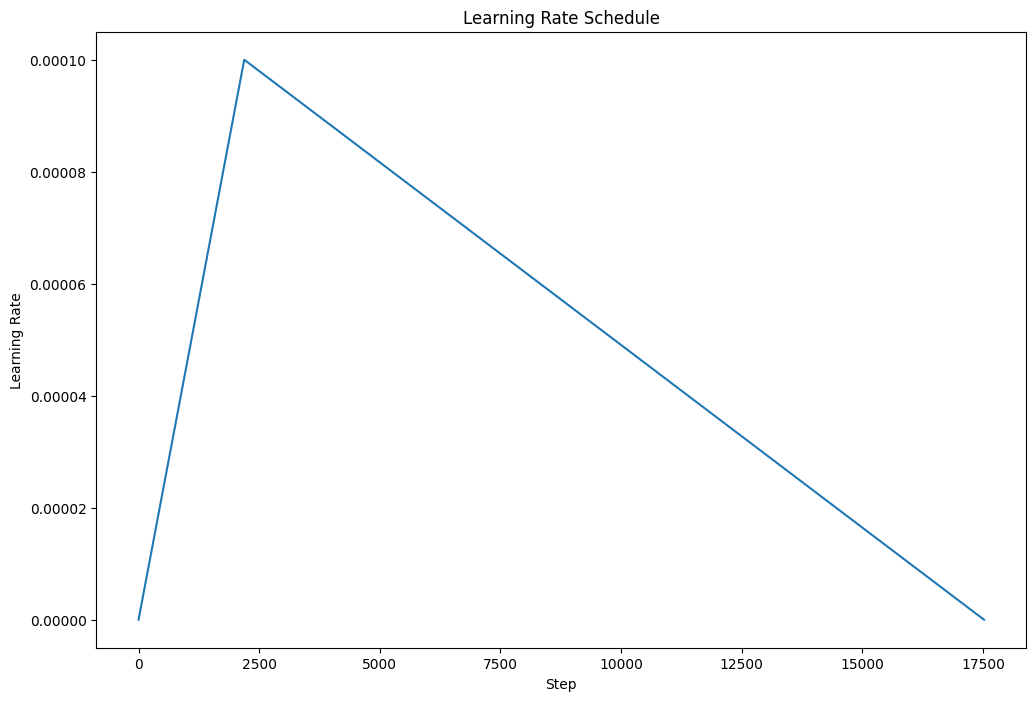

In [ ]:
# Archived output——plotting the designed LR vs. step
# # NOTE: If you run this, you over-write the model, optimizer, and scheduler. Be sure to re-instantiate them before training!

# model = torch.nn.Linear(2, 1)
# optimizer = torch.optim.SGD(model.parameters(), 1e-4)

# num_training_steps = EPOCHS * len(train_dataloader)
# scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=len(train_dataloader)*0.5,
#     num_training_steps=num_training_steps,
# )

# lrs = []
# for i in range(num_training_steps):
#     optimizer.step()
#     lrs.append(scheduler.get_last_lr()[0])
#     scheduler.step()

# plt.figure(figsize=(12,8))
# plt.plot(range(num_training_steps),lrs)
# plt.title('Learning Rate Schedule')
# plt.xlabel('Step')
# plt.ylabel('Learning Rate')

# Training

In [ ]:
def train(model, train_dataloader, val_dataloader, device, optimizer, scheduler):
    """
    Trains the specified model.
    """
    train_losses = []
    val_losses = []

    model.train()

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch}, Learning rate: {scheduler.get_last_lr()[0]:.5f}")
        epoch_loss = []
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            start = time.time()
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids,
                            attention_mask=attention_mask,
                            start_positions=start_positions,
                            end_positions=end_positions)

            # outputs has keys 'loss', 'start_logits', 'end_logits', 'encoder_last_hidden_state'
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()
            stop = time.time()

            if step % 400 == 0: # note this will run on the first step also
              train_losses.append(loss.item())
              # Calculate validation loss on a single batch only for compute reasons
              val_batch = next(iter(val_dataloader))
              with torch.no_grad():
                model.eval()
                output = model(val_batch['input_ids'].to(device),
                              attention_mask=val_batch['attention_mask'].to(device),
                              start_positions=val_batch['start_positions'].to(device),
                              end_positions=val_batch['end_positions'].to(device))
                val_loss = output.loss
                val_losses.append(val_loss.item())
              model.train()

              # Print statistics
              print(f"Epoch: {epoch+1}/{EPOCHS} | Step: {step}/{len(train_dataloader)} | Train Loss: {loss.item():.5f} | Val Loss: {val_loss.item():.5f} |",
                    f"LR: {scheduler.get_last_lr()[0]:.5f} | Time of Last Batch: {stop-start:.2f} \n")

        avg_train_loss = total_loss / len(train_dataloader)
        epoch_loss.append(avg_train_loss)

        print(f"Epoch {epoch}, Train Loss: {avg_train_loss}")

In [ ]:
train(model, train_dataloader, val_dataloader, device, optimizer, scheduler)

Epoch 1, Learning rate: 4e-05
Epoch: 2/3 | Step: 0/8760 | Train Loss: 0.84792 | Val Loss: 1.36571 | Time of Last Batch: 0.97 

Epoch: 2/3 | Step: 400/8760 | Train Loss: 0.99144 | Val Loss: 2.51338 | Time of Last Batch: 1.17 

Epoch: 2/3 | Step: 800/8760 | Train Loss: 0.79753 | Val Loss: 1.24453 | Time of Last Batch: 1.16 



In [ ]:
### Code was re-run above during an incomplete secondary training run

In [ ]:
# Save model
model.save_pretrained("/content/drive/Shareddrives/T5-QA/t5-squad-tuned")

## Plot losses

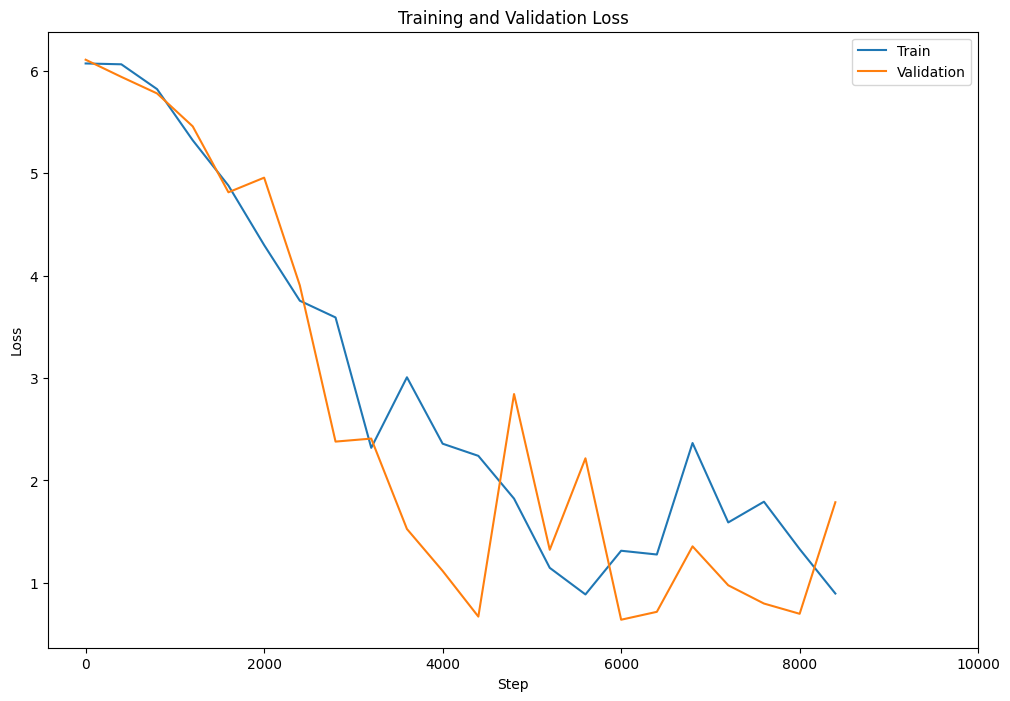

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.xticks(ticks=plt.xticks()[0][1:], labels=400 * np.array(plt.xticks()[0][1:], dtype=int)) # steps * 400
plt.legend()
plt.show()
plt.savefig("/content/drive/Shareddrives/T5-QA/figures/loss.png")

# Evaluation

Here we build out our official post-processing function.

Goals: We must exclude start and end indices that give:  
--An answer which falls outside of the context paragraph (e.g. it represents padding or text that is part of the question instead)  
--An answer with negative length (start_index > end_index)  
--An answer that is too long

We follow Huggingface's approach:  
  i) Sort start and end logits  
  ii) Loop through most probable start and end predictions and validate—if valid, append to candidate list and decode  
  iii) Finally, to select the final prediction, choose the candidate with the greatest *sum* of start and end logits

In [18]:
# Hyperparameters:
n_best = 10 # number of start and end indices to consider as candidates (no need to check all 384 logits)
max_answer_len = 30 # max token length of a predicted answer

In [19]:
def retrieve_preds_and_labels(start_logits, end_logits,
                input_ids, seq_ids,
                start_pos=None, end_pos=None,
                n_best=10, max_answer_len=30,
                inference=False):
  """
  Mapping helper function which post-processes and decodes fine-tuned T5ForQuestionAnswering model outputs
  as well as decoded ground truth labels.

  Inputs:
    -Start_logits and end_logits refer to the model output
    -Input_ids and seq_ids refer to the tokenized input
    -All are tensors of length `seq_len`
    -Start_pos and end_pos refer to the token indices of the ground truth labels if given and are tensors of length 1
    -n_best (int): Number of each of start and end indices to consider as candidates (no need to check all `seq_len` logits)
    -max_answer_len (int): Max token length of a predicted answer
    -inference (bool=True): If true, processes labels
  Returns:
    -Tuple of two lists, each of length batch_size
      -Decoded model predictions
      -Decoded ground truth labels
    -If inference=True, only the predictions are returned as a 1-tuple

  """
  assert isinstance(n_best, int) and isinstance(max_answer_len, int) and n_best > 0 and max_answer_len > 0

  start_idx_list = np.argsort(start_logits.cpu().numpy())[-1:(-n_best-1):-1]
  end_idx_list = np.argsort(end_logits.cpu().numpy())[-1:(-n_best-1):-1]
  # requires cpu to use np.argsort and requires numpy for negative indexing
  # start_idx_list, end_idx_list are lists of length `n_best`. Now we check all n_best^2 combinations

  valid_answers = []
  for start_idx in start_idx_list:
      for end_idx in end_idx_list:
          # Ignore out-of-scope answers (i.e. indices of predicted answer is outside the context)
          if (

              # to do so, we make use of sequence id. If not 1 then the index is outside the context, because 0 => part of qusstion
              # and None => special token

              seq_ids[start_idx].item()!= 1
              or seq_ids[end_idx].item()!= 1
          ):
              continue
          # Ignore answers with negative length or > max_answer_len
          if start_idx > end_idx or end_idx - start_idx + 1 > max_answer_len:
              continue

          # If this start end index pair survives it's valid
          # we sum the start and end logits
          valid_answers.append(
              {
                  "score": start_logits[start_idx] + end_logits[end_idx],
                  'start_idx': start_idx,
                  'end_idx': end_idx
              }
          )

  # take prediction with max score, only decode this prediction (no need to decode all candidates)
  final_preds = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
  final_decoded_preds = tokenizer.decode(input_ids[final_preds['start_idx']
                                    :(final_preds['end_idx']+1)])

  # Now decode ground truth labels
  if not inference:
    labels = tokenizer.decode(input_ids[start_pos:(end_pos+1)])
    return final_decoded_preds, labels
  else:
    return (final_decoded_preds,)

In [20]:
def postprocess(batch, output, inference=False, **kwargs):
    """
    Postprocesses and decodes model output (and ground truth labels if any).

    Inputs;
      -batch: The data batch returned from the DataLoader
      -output: Output of the model when given `batch`
      -inference (bool=False): Indicates if labels are available and decodes + returns them if so
    Returns:
      -2-tuple of numpy arrays of length `batch_size` indicating the model predictions and the ground truth labels respectively
      -Note: If set to inference mode (i.e. no labels), only the predictions are returned, and not in 1-tuple form.
    """

    # batch size used
    b_size = batch['input_ids'].size(0)

    # prepare map function with fixed inference and keyword arguments
    mapfunc = partial(retrieve_preds_and_labels, inference=inference, **kwargs)

    # if inference, no start/end positions, and we initialize placeholder tensors
    if inference:
      start_pos, end_pos = torch.empty((b_size,1)), torch.empty((b_size,1))
    else:
      start_pos, end_pos = batch['start_positions'], batch['end_positions']

    # map helper function
    postprocessed_output = list(map(mapfunc, output.start_logits, output.end_logits,
                                        batch['input_ids'], batch['sequence_ids'],
                                        start_pos, end_pos))

    # output shape above: list of length `batch_size` of 2-tuples (pred, label) or 1-tuple (pred, )

    preds = np.array([postprocessed_output[i][0] for i in range(b_size)])
    if not inference:
      labels = np.array([postprocessed_output[i][1] for i in range(b_size)])
      return preds, labels
    else:
      return preds

## Evaluation metrics

In [ ]:
def normalization(text):
  """
  Normalizes a given text by fixing whitespaces, converting to lowercase, and removing punctuation.
  This function does not remove stopwords, articles, or translate numbers to words as these actions
  can affect the length of the strings and thus the F-1 score.

  Input:
      -text (str): Text string to be normalized
  Returns:
      -The normalized text string
  """
  # Fix whitespaces, convert lowercase
  text = " ".join(text.split()).lower()

  # Remove punctuation
  text = text.translate(str.maketrans("", "", string.punctuation))

  return text

### i) Exact match

In [ ]:
def exact_match(preds, labels):
  """
  Calculates the exact match score between predictions and labels.
  Normalizes the predictions and labels first, then computes the proportion of equality between normalized predictions and labels.

  Input:
      -preds (np.array): Array of prediction strings
      -labels (np.array): Array of label strings
  Returns:
      -Exact match score (float) between the normalized predictions and labels

  """
  # Normalize predictions and labels
  preds = np.vectorize(normalization)(preds)
  labels = np.vectorize(normalization)(labels)

  return np.mean(preds == labels)


### ii) F-1 score

In [ ]:
def f1(preds, labels):
  """
  Computes F-1 score word-level.

  Input:
      -preds (np.array): Array of prediction strings
      -labels (np.array): Array of label strings
  Returns:
      -Mean F-1 score (float) for all pairs of normalized predictions and labels
  """

  f1_list = []

  # Normalize predictions and labels
  preds = np.vectorize(normalization)(preds)
  labels = np.vectorize(normalization)(labels)

  # Calculates F-1 Score for each pair of preds & labels
  for i in range(len(preds)):
    pred_tokens = preds[i].split()
    act_tokens = labels[i].split()

    common_tokens = set(pred_tokens) & set(act_tokens)
    if len(common_tokens) == 0:
      f1_list.append(0)
    else:
      pre = len(common_tokens) / len(pred_tokens)
      rec = len(common_tokens) / len(act_tokens)
      f1 =  2 * (pre * rec) / (pre + rec)
      f1_list.append(f1)

  return np.mean(f1_list)

### iii) NLG metrics (BLEU, ROUGE, METEOR)

We will simply load these in from HuggingFace's *evaluate* library.

### iv) Semantic Answer Similarity (SAS)
*https://arxiv.org/abs/2108.06130*

Idea: Feed the two sentences to a BERT-model fine-tuned for semantic textual similarity (STS) (specifically on the STS Benchmark dataset) and retrieve its similarity score.

In [24]:
def sas(cross_encoder, preds, labels):
  """
  Computes Semantic Answer Similarity (SAS) scores between predictions and labels via a cross-encoder.

  Input:
      -cross_encoder: Cross-encoder model used for prediction
      -preds (np.array): Array of prediction strings
      -labels (np.array): Array of label strings
  Returns:
      -Mean SAS score (float) for all prediction-label pairs

  """
  cross_encoder_input = [(preds[i], labels[i]) for i in range(len(preds))]
  sas_scores = cross_encoder.predict(cross_encoder_input)

  return sas_scores.mean()

### Evaluate model performance

In [ ]:
def eval_acc(model, val_dataloader):
  """
  Evaluates the accuracy of a model on the validation dataset using various metrics:
    -EM, F1, METEOR, ROUGE-1, ROUGE-2, ROUGE-L, and SAS

  Input:
      -model: Model to be evaluated
      -val_dataloader: Data loader for the validation dataset
  Returns:
      -A dictionary containing the mean accuracy scores for each metric
  """

  # Setting up the evaluation metrics
  meteor = evaluate.load('meteor')
  rouge = evaluate.load('rouge')
  bleu = evaluate.load("bleu")
  cross_encoder = CrossEncoder('cross-encoder/stsb-roberta-large')

  # Put the model into evaluation mode
  model.eval()

  # Initialize lists to store accuracy scores
  em_list = []
  f1_list = []
  meteor_list = []
  rouge_1_list, rouge_2_list, rouge_L_list = [], [], []
  bleu_list = []
  sas_list = []

  # Evaluate model
  with torch.no_grad():
    print('Evaluating Validation Accuracies:')
    for batch in tqdm(val_dataloader):
      output = model(batch['input_ids'].to(device),
                    attention_mask=batch['attention_mask'].to(device),
                    start_positions=batch['start_positions'].to(device),
                    end_positions=batch['end_positions'].to(device))

      preds, labels = postprocess(batch, output, inference=False,
                                  n_best=10, max_answer_len=30)

      # Compute accuracy
      em_val = exact_match(preds, labels)
      f1_val = f1(preds, labels)
      meteor_val = meteor.compute(predictions=preds, references=labels)['meteor']

      rouge_val = rouge.compute(predictions=preds, references=labels)
      rouge_1 = rouge_val['rouge1']
      rouge_2 = rouge_val['rouge2']
      rouge_L = rouge_val['rougeL']

      bleu_val = bleu.compute(predictions=preds, references=labels)['bleu']
      sas_val = sas(cross_encoder, preds, labels)

      # Append accuracy scores to the corresponding lists
      em_list.append(em_val)
      f1_list.append(f1_val)
      meteor_list.append(meteor_val)
      rouge_1_list.append(rouge_1)
      rouge_2_list.append(rouge_2)
      rouge_L_list.append(rouge_L)
      bleu_list.append(bleu_val)
      sas_list.append(sas_val)

  # Compute and print average accuracy scores
  em_score = np.mean(em_list)
  f1_score = np.mean(f1_list)
  meteor_score = np.mean(meteor_list)
  rouge_1_score = np.mean(rouge_1_list)
  rouge_2_score = np.mean(rouge_2_list)
  rouge_L_score = np.mean(rouge_L_list)
  bleu_score = np.mean(bleu_list)
  sas_score = np.mean(sas_list)

  print(f"\n\nExact Match: {em_score}")
  print(f"F1: {f1_score}")
  print(f"METEOR: {meteor_score}")
  print(f"ROUGE-1: {rouge_1_score}")
  print(f"ROUGE-2: {rouge_2_score}")
  print(f"ROUGE-L: {rouge_L_score}")
  print(f"BLEU: {bleu_score}")
  print(f"SAS: {sas_score}")

  metrics_dict = {'EM': em_score,
                 'F1': f1_score,
                 'METEOR': meteor_score,
                 'ROUGE-1': rouge_1_score,
                 'ROUGE-2': rouge_2_score,
                 'ROUGE-L': rouge_L_score,
                 'BLEU': bleu_score,
                 'SAS': sas_score}

  return metrics_dict

In [ ]:
metrics_dict = eval_acc(model, val_dataloader)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluating Validation Accuracies:


100%|██████████| 1095/1095 [12:23<00:00,  1.47it/s]

Exact Match: 0.5974885844748858
F1: 0.7740340906290476
METEOR: 0.6140318302160169
ROUGE-1: 0.7863754277374584
ROUGE-2: 0.48721975400827106
ROUGE-L: 0.7854694032042838
BLEU: 0.4802889269356261
SAS: 0.7990536689758301


In [ ]:
metrics_dict

{'EM': 0.5974885844748858,
 'F1': 0.7740340906290476,
 'METEOR': 0.6140318302160169,
 'ROUGE-1': 0.7863754277374584,
 'ROUGE-2': 0.48721975400827106,
 'ROUGE-L': 0.7854694032042838,
 'BLEU': 0.4802889269356261,
 'SAS': 0.79905367}

# Inference

In [14]:
# Load in our fine-tuned model
config = LoraConfig.from_pretrained('/content/drive/Shareddrives/T5-QA/t5-squad-tuned')

model = AutoModelForQuestionAnswering.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, '/content/drive/Shareddrives/T5-QA/t5-squad-tuned')

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path, use_fast=True)
model.to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForQuestionAnswering were not initialized from the model checkpoint at t5-small and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForQuestionAnswering(
  (base_model): LoraModel(
    (model): T5ForQuestionAnswering(
      (shared): Embedding(32128, 512)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 512)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=512, out_features=512, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=512, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=512, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B)

In [ ]:
def predict(model, tokenizer, question, context):
    """
    Uses the specified QA model and tokenizer to perform extractive question answering on a given question and context string.
    1. Tokenizes the question and context
    2. Makes predictions using the model and postprocesses the output
    3. Returns the model prediction

    Input:
        -model: QA model to be used for prediction
        -tokenizer: Tokenizer to be used for tokenizing the question and context
        -question (str): Question string
        -context (str): Context string
    Returns:
        -Model prediction (str)

    """

    # Tokenize the question and context
    input = tokenizer(question, context,
          max_length=384,
          truncation="only_second",
          padding="max_length"
          )

    # convert from native Python lists to tensors
    # also add a dimension since we are not feeding in a batch but model expects extra batch dim
    for key in input:
      input[key] = torch.tensor(input[key], dtype=torch.int64).unsqueeze(0)

    # convert sequence_ids to tensors and add new dim as well, assign to new attribute
    input['sequence_ids'] = torch.tensor(np.array(input.sequence_ids(), dtype=float)).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        inference_output = model(input['input_ids'].to(device),
                                attention_mask=input['attention_mask'].to(device))
    pred = postprocess(input, inference_output, inference=True)[0] # extract from list of length 1 cause we only feed it one example

    return pred

#### Test case 1:

In [ ]:
question = "How many weeks are in an academic quarter at UCLA?"
context = "UCLA operates on a quarter system, which means that the academic year is divided into three 10-week quarters. \
On the other hand, UC Berkeley operates on a semester system, which means that the academic year is divided into two 15-week semesters. \
This can affect the pace of classes and the timing of exams and breaks. Additionally, some students may find that they have more opportunities \
to take classes with a quarter system, while others may prefer the longer semester format. Overall, the main difference is the length of the \
academic terms, but it also affects the pace of classes and the timing of exams and breaks."

In [ ]:
pred = predict(model, tokenizer, question, context)
pred

'10-'

#### Test case 2:

In [ ]:
question = "Name the musicians that Laufey have cited as influential in her music."
context = "Laufey Lín Jónsdóttir (/ˈleɪveɪ/ LAY-vay, Icelandic: [ˈlœyːvei ˈliːn ˈjounstouhtɪr̥]; born 23 April 1999), known by the mononym Laufey, \
is an Icelandic singer-songwriter.[2] She achieved notability in the early 2020s, and describes her musical style, a mixture of \
jazz pop and bedroom pop, as 'modern jazz'.[3] Having performed as a cello soloist with the Iceland Symphony Orchestra at age 15, Laufey was a \
finalist on Ísland Got Talent (2014) and semi-finalist on The Voice Iceland (2015). In 2021, she released her debut EP, Typical of Me, and graduated \
from the Berklee College of Music in Boston, United States. Laufey's debut album, Everything I Know About Love, was released in 2022 and charted in \
Iceland and the US. It was followed by Bewitched, which was released in 2023 to critical acclaim and earned her a Best Traditional Pop Vocal Album \
nomination at the 2024 Grammy Awards; the single 'From the Start' found moderate success in Canada, New Zealand and the United Kingdom. Laufey has \
cited Ella Fitzgerald, Billie Holiday, Chet Baker and Taylor Swift as sources of influence."

In [ ]:
pred = predict(model, tokenizer, question, context)
pred

'Ella Fitzgerald, Billie Holiday, Chet Baker and Taylor Swift'

#### Test case 3:

In [ ]:
question = "Name the group members that worked on this project."
context = "The grading scheme of Math 156 --Machine Learning-- during \
Fall 2023 consists of three assignments, two midterms, and a project. One group in the class focused \
their project on natural language processing (NLP). The \
names of the members of that group are Terry Ming, Seita Yoshifusa, Christopher Fu, and Nam Truong. \
They started working on the project since week 3 of the quarter and \
will be assigned a random date to present their project to the class."

In [ ]:
pred = predict(model, tokenizer, question, context)
pred

'Terry Ming, Seita Yoshifusa, Christopher Fu, and Nam Truong'

#### Test case 4:

In [ ]:
question = "What new model is believed to represent a closer step towards AGI?"
context = "Ahead of OpenAI CEO Sam Altman’s four days in exile, several staff researchers wrote a letter to the board of directors \
warning of a powerful artificial intelligence discovery that they said could threaten humanity, two people familiar with the matter told Reuters. \
The previously unreported letter and AI algorithm were key developments before the board's ouster of Altman, the poster child of generative AI, \
the two sources said. Prior to his triumphant return late Tuesday, more than 700 employees had threatened to quit and join backer Microsoft (MSFT.O) \
in solidarity with their fired leader. After being contacted by Reuters, OpenAI, which declined to comment, acknowledged in an internal message to \
staffers a project called Q* and a letter to the board before the weekend's events, one of the people said. Some at OpenAI believe Q* \
(pronounced Q-Star) could be a breakthrough in the startup's search for what's known as artificial general intelligence (AGI), \
one of the people told Reuters."

# https://www.reuters.com/technology/sam-altmans-ouster-openai-was-precipitated-by-letter-board-about-ai-breakthrough-2023-11-22/

In [ ]:
pred = predict(model, tokenizer, question, context)
pred

'Q* (pronounced Q-Star'

#### Test case 5:

In [ ]:
question = "Which electives from the Statistics department can an Applied Math major take?"
context = "Required: Mathematics 31A or 31AL, 31B, 32A, 32B, 33A, 33B, Physics 1A, 1B, Program in Computing 10A, and one course \
from Chemistry and Biochemistry 20A, 20B, Physics 1C. \n\n Required: Mathematics 115A, 131A, either 131B or 132, 142; two two-term \
sequences from two of the following categories: numerical analysis—courses 151A and 151B, probability and statistics—courses 170A and 170B, \
or Statistics 100A and 100B, differential equations—courses 134 and 135; four courses from 106 through 199 and Statistics 100A through 102C \
(appropriate courses from other departments may be substituted for some of the additional courses provided departmental consent is \
given before such courses are taken). Mathematics 115A is required of all majors and is intended to be the first upper-division course taken. \
It is strongly advised that students take Mathematics 115A as soon as the major is declared, if not earlier."

In [ ]:
pred = predict(model, tokenizer, question, context)
pred

'Statistics 100A through 102C'